# Bioinformatics on IPFS

Welcome to the [dClimate](https://www.dclimate.net/) Bioinformatics notebook. This notebook describes how to create an "ETL" to ingest Bioinformatics data into IPFS. This notebook serves as the bioinformatics companion to the [Creating an ETL - CPC](./Creating%20an%20ETL%20-%20CPC.ipynb) which describes the steps to ingest [GIS](https://en.wikipedia.org/wiki/Geographic_information_system) data into IPFS to be able to read it later. To learn more about our architecture, why use this, and how to read data check out the [Getting Started](./Getting%20Started.ipynb) notebook. 

We encourage you to fork this notebook, adapt it for your needs, 

In [1]:
!uv pip install numpy==2.1 xarray==2024.11.0 zarr==2.18.4 pandas multiformats git+https://github.com/dClimate/py-hamt.git sgkit[vcf]

Using Python 3.12.7 environment at: /opt/venv
Resolved 75 packages in 1.54s                                        
Audited 75 packages in 2ms


# Fetching Remote Data

Why are we doing this? We want to pull VCF data from elsewhere and convert it locally to a Zarr which can be read.

In [2]:
import io
import requests
import sgkit as sg
from sgkit.io.vcf import vcf_to_zarr
from py_hamt import HAMT, IPFSStore
import xarray as xr
from multiformats import CID
import numcodecs  # For compression if needed

# URL of the file
url = "https://github.com/jeyabbalas/vcf-to-zarr/blob/main/data/vcf/simple.vcf.gz?raw=true"

# Filepath where you want to save the downloaded file
output_file = "downloaded_data/bio/simple.vcf.gz"

# Download the file with streaming
response = requests.get(url, stream=True)
response.raise_for_status()  # Ensure the request was successful

# Write the file content to the output file
with open(output_file, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):  # Download in chunks of 8 KB
        f.write(chunk)

print(f"File downloaded and saved as: {output_file}")

# Uncomment out these lines if you wish to see what the function is doing
# import inspect
# from sgkit.io.vcf import vcf_to_zarr
# lines = inspect.getsource(vcf_to_zarr)
# print(lines)
vcf_to_zarr(output_file, "processed_data/bio/output.zarr")


# Tsgkit.load_dataset is a wrapper around xr.open_zarr("output.zarr")  
ds = sg.load_dataset("processed_data/bio/output.zarr")
ds

File downloaded and saved as: downloaded_data/bio/simple.vcf.gz


<xarray.Dataset> Size: 404B
Dimensions:               (variants: 5, samples: 3, ploidy: 2, contigs: 1,
                           filters: 3, alleles: 4)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                alleles
Data variables: (12/14)
    call_genotype         (variants, samples, ploidy) int8 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 15B dask.array<chunksize=(5, 3), meta=np.ndarray>
    contig_id             (contigs) <U2 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 24B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                    ...
    variant_contig        (variants) int8 5B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_filter        (variants, filters) bool 15B dask.array<chunksize=(5, 3), meta=np.ndarray>
    variant_id            (variants) object 40B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_id_mask       (variants) bool 5B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_position      (variants) int32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_quality       (variants) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Attributes:
    contig_lengths:        [62435964]
    contigs:               ['20']
    filters:               ['PASS', 'q10', 's50']
    max_alt_alleles_seen:  2
    source:                sgkit-0.8.0
    vcf_header:            ##fileformat=VCFv4.3\n##FILTER=<ID=PASS,Descriptio...
    vcf_zarr_version:      0.2

# Preparing and Adding to IPFS

We will take the existing Zarr that was converted from the VCF file, and prepare & load it to IPFS so that it can be shared and read directly with IPFS instead of from a remote server.

In [3]:
import numpy as np

ds = xr.open_zarr("processed_data/bio/output.zarr")  # type: ignore[no-untyped-call]
for v in ds:
    # Workaround for https://github.com/pydata/xarray/issues/4386
    if v.endswith("_mask"):  # type: ignore
        ds[v] = ds[v].astype(bool)

def load_zarr_to_ipfs(zarr_path: str, cid_out_path: str = None) -> str:
    """
    Put the Zarr store onto IPFS using py-hamt. Returns the root CID as a string.
    If cid_out_path is provided, also write the CID to a file.

    :param zarr_path: Path to the local Zarr directory.
    :param cid_out_path: Optional path to write the CID (e.g. "cpc_conus.cid").
    :return: The root CID string
    """
    print(f"Loading {zarr_path} onto IPFS via py-hamt...")
    hamt_store = HAMT(store=IPFSStore())  # By default uses local IPFS daemon at 127.0.0.1:5001
    ds = xr.open_zarr(zarr_path)
    for v in ds:
        # Workaround for https://github.com/pydata/xarray/issues/4386
        if v.endswith("_mask"):  # type: ignore
            ds[v] = ds[v].astype(bool)

    """
    Convert any object-typed data variables or coords to string type
    to avoid TypeError with VLenUTF8 when storing to Zarr.
    """
    for var_name in ds.variables:
        if ds[var_name].dtype == object:
            arr = ds[var_name].values
            # Filter out None or empty entries if needed
            # Flatten if it is multi-dimensional with strings in each cell
            flat = arr.ravel()
            # Convert all items to str, to be safe
            str_vals = [str(x) for x in flat if x is not None]
            max_len = max(len(s) for s in str_vals) if str_vals else 1
            ds[var_name] = ds[var_name].astype(f"U{max_len}")
            
    ds.to_zarr(store=hamt_store, mode="w")

    root_cid_str = str(hamt_store.root_node_id)
    print(f"Successfully wrote data to IPFS. Root CID = {root_cid_str}")

    if cid_out_path:
        with open(cid_out_path, "w") as f:
            f.write(root_cid_str + "\n")

    return root_cid_str

# 4. Put the new "cpc_conus_demo.zarr" on IPFS
root_cid = load_zarr_to_ipfs(
    zarr_path="processed_data/bio/output.zarr",
    cid_out_path="output_data/bio/bioinformatics.cid"
)


Loading processed_data/bio/output.zarr onto IPFS via py-hamt...
Successfully wrote data to IPFS. Root CID = bafyr4icdf3tfgjzvop7um42fej3l5gpj7r7rzxslnmd4sd5idzx5j75bfe


# Reading Zarr on IPFS

Below you can see we use the root_cid (content identifier) hash within xarray which resulted from the ETL above

In [4]:
import xarray as xr
from py_hamt import HAMT, IPFSStore
from multiformats import CID

decoded_root_cid = CID.decode(root_cid)

# Create HAMT instance using the IPFSStore connecting to your locally running IPFS Gateway from your local running IPFS Node
hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080"), root_node_id=decoded_root_cid)

# Open the Zarr Genomic Dataset loded from IPFS directly using a hash, not a URL (!!) 
ds = xr.open_zarr(store=hamt)
print(ds)

<xarray.Dataset> Size: 788B
Dimensions:               (variants: 5, samples: 3, ploidy: 2, contigs: 1,
                           filters: 3, alleles: 4)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                alleles
Data variables: (12/14)
    call_genotype         (variants, samples, ploidy) int8 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 15B dask.array<chunksize=(5, 3), meta=np.ndarray>
    contig_id             (contigs) <U2 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) <U4 48B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                    ...
    variant_contig        (variants) int8 5B dask.array<chunksize=(5,), meta=np.ndarr

Let's set the dataset(ds) to the callset variable

In [5]:
callset = ds
callset

<xarray.Dataset> Size: 788B
Dimensions:               (variants: 5, samples: 3, ploidy: 2, contigs: 1,
                           filters: 3, alleles: 4)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                alleles
Data variables: (12/14)
    call_genotype         (variants, samples, ploidy) int8 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 30B dask.array<chunksize=(5, 3, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 15B dask.array<chunksize=(5, 3), meta=np.ndarray>
    contig_id             (contigs) <U2 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) <U4 48B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                    ...
    variant_contig        (variants) int8 5B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_filter        (variants, filters) bool 15B dask.array<chunksize=(5, 3), meta=np.ndarray>
    variant_id            (variants) <U9 180B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_id_mask       (variants) bool 5B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_position      (variants) int32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    variant_quality       (variants) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Attributes:
    contig_lengths:        [62435964]
    contigs:               ['20']
    filters:               ['PASS', 'q10', 's50']
    max_alt_alleles_seen:  2
    source:                sgkit-0.8.0
    vcf_header:            ##fileformat=VCFv4.3\n##FILTER=<ID=PASS,Descriptio...
    vcf_zarr_version:      0.2

Verify that the samples exist as they do in the original VCF via simple native xarray retrieval

In [6]:
ds["sample_id"].values

array(['NA00001', 'NA00002', 'NA00003'], dtype='<U7')

Use sgkit to do a basic call to display genotypes for each sample

In [7]:
sg.display_genotypes(ds, max_variants=10)

samples,NA00001,NA00002,NA00003
variants,,,
0,0|0,1|0,1/1
1,0|0,0|1,0/0
2,1|2,2|1,2/2
3,0|0,0|0,0/0
4,0/1,0/2,1/1


We can also list all variants with their associated position

In [8]:
# 1. Map variant IDs if available
variant_ids = ds["variant_id"].values  # Array of variant names/IDs

# 2. Map contig names and positions
contig_names = ds["contig_id"].values  # Array of contig names
variant_contigs = ds["variant_contig"].values  # Contig indices for variants
variant_positions = ds["variant_position"].values  # Variant positions

# Create readable variant names (e.g., "chr1:12345")
variant_names = [
    f"{contig_names[contig]}:{pos}"
    for contig, pos in zip(variant_contigs, variant_positions)
]

# 3. Map variant alleles if needed
variant_alleles = ds["variant_allele"].values  # Allele strings for variants

# Example of creating detailed annotations for variants
detailed_variant_names = [
    f"{contig_names[contig]}:{pos} {alleles}"
    for contig, pos, alleles in zip(variant_contigs, variant_positions, variant_alleles)
]

# Example output
for i, name in enumerate(variant_names):
    print(f"Variant {i}: {name}")

Variant 0: 20:14370
Variant 1: 20:17330
Variant 2: 20:1110696
Variant 3: 20:1230237
Variant 4: 20:1234567


# GWAS Tutorial

This has been copied from https://sgkit-dev.github.io/sgkit/0.3.0/examples/gwas_tutorial.html which itself is based on the tutorial from Hail https://nbviewer.jupyter.org/github/tomwhite/sgkit/blob/86753e814c6d56982b6950ec3de727f3b1bfad7d/docs/examples/01-genome-wide-association-study.ipynb which we highly recommend you read in order to understand what is being done in the following notebook. The only difference in our tutorial is that we do all computations from genomic data living on IPFS instead.

Download public 1000 Genomes data¶
We use the same small (20MB) portion of the public 1000 Genomes data that Hail uses.

First, download the file locally:

In [12]:
from pathlib import Path
import requests

if not Path("downloaded_data/bio/1kg.vcf.bgz").exists():
    response = requests.get("https://storage.googleapis.com/sgkit-gwas-tutorial/1kg.vcf.bgz")
    with open("downloaded_data/bio/1kg.vcf.bgz", "wb") as f:
        f.write(response.content)

Importing data from VCF¶
Next, convert it to Zarr, stored on the local filesystem in a directory called 1kg.zarr.

In [13]:
vcf_to_zarr("downloaded_data/bio/1kg.vcf.bgz", "processed_data/bio/1kg.zarr", max_alt_alleles=1,
          fields=["FORMAT/GT", "FORMAT/DP", "FORMAT/GQ", "FORMAT/AD"],
          field_defs={"FORMAT/AD": {"Number": "R"}})

[W::bcf_hdr_check_sanity] PL should be declared as Number=G


In [14]:
root_cid = load_zarr_to_ipfs(
    zarr_path="processed_data/bio/1kg.zarr",
    cid_out_path="output_data/bio/gwas_tutorial.cid"
)

Loading processed_data/bio/1kg.zarr onto IPFS via py-hamt...
Successfully wrote data to IPFS. Root CID = bafyr4igjt6fvbpabbmkxq6tvwvw4icnm356o6txtziaqgsagkahmvzjjna


In [15]:
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data_vars=True);

In [16]:
import xarray as xr
from py_hamt import HAMT, IPFSStore
from multiformats import CID

decoded_root_cid = CID.decode(root_cid)

# Create HAMT instance using the IPFSStore connecting to your locally running IPFS Gateway from your local running IPFS Node
hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080"), root_node_id=decoded_root_cid)

# Open the Zarr Genomic Dataset loded from IPFS directly using a hash, not a URL (!!) 
ds = xr.open_zarr(store=hamt)
print(ds)

<xarray.Dataset> Size: 65MB
Dimensions:               (variants: 10879, samples: 284, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: variants, samples, alleles, ploidy, contigs,
                                filters
Data variables: (12/17)
    call_AD               (variants, samples, alleles) int32 25MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_DP               (variants, samples) int32 12MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_GQ               (variants, samples) int32 12MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 6MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 6MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 3MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    ...         

In [17]:
ds["variant_contig_name"] = (["variants"], [ds.contigs[contig] for contig in ds["variant_contig"].values])
ds2 = ds.set_index({"variants": ("variant_contig_name", "variant_position", "variant_id")})
sg.display_genotypes(ds2, max_variants=10, max_samples=5)

samples,HG00096,HG00099,...,NA21133,NA21143
variants,,,,,
"(0, 904165, .)",0/0,0/0,...,0/0,0/0
"(0, 909917, .)",0/0,0/0,...,0/0,0/0
"(0, 986963, .)",0/0,0/0,...,0/0,0/0
"(0, 1563691, .)",./.,0/0,...,0/0,0/0
"(0, 1707740, .)",0/1,0/1,...,0/1,0/0
...,...,...,...,...,...
"(22, 152660491, .)",./.,0/0,...,1/1,0/0
"(22, 153031688, .)",0/0,0/0,...,0/0,0/0
"(22, 153674876, .)",0/0,0/0,...,0/0,0/0


We can show the alleles too.

Note: this needs work to make it easier to do

In [18]:
df_variant = ds[[v for v in ds.data_vars if v.startswith("variant_")]].to_dataframe()
df_variant.groupby(["variant_contig_name", "variant_position", "variant_id"]).agg({"variant_allele": lambda x: list(x)}).head(5)

variant_allele
variant_contig_name variant_position variant_id               
0                   904165           .                  [G, A]
                    909917           .                  [G, A]
                    986963           .                  [C, T]
                    1563691          .                  [T, G]
                    1707740          .                  [T, G]

Show the first five sample IDs by referencing the dataset variable directly:

In [19]:
ds.sample_id[:5].values


array(['HG00096', 'HG00099', 'HG00105', 'HG00118', 'HG00129'], dtype='<U7')

# Adding column fields

Xarray datasets can have any number of variables added to them, possibly loaded from different sources. Next we’ll take a text file (CSV) containing annotations, and use it to annotate the samples in the dataset.

First we load the annotation data using regular Pandas.

In [20]:
ANNOTATIONS_FILE = "https://storage.googleapis.com/sgkit-gwas-tutorial/1kg_annotations.txt"
df = pd.read_csv(ANNOTATIONS_FILE, sep="\t", index_col="Sample")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, HG00096 to NA21144
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Population           3500 non-null   object
 1   SuperPopulation      3500 non-null   object
 2   isFemale             3500 non-null   bool  
 3   PurpleHair           3500 non-null   bool  
 4   CaffeineConsumption  3500 non-null   int64 
dtypes: bool(2), int64(1), object(2)
memory usage: 116.2+ KB


In [22]:
df

,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption
Sample,,,,,
HG00096,GBR,EUR,False,False,4
HG00097,GBR,EUR,True,True,4
HG00098,GBR,EUR,False,False,5
HG00099,GBR,EUR,True,False,4
HG00100,GBR,EUR,True,False,5
...,...,...,...,...,...
NA21137,GIH,SAS,True,False,1
NA21141,GIH,SAS,True,True,2
NA21142,GIH,SAS,True,True,2


In [23]:
ds_annotations = pd.DataFrame.to_xarray(df).rename({"Sample":"samples"})
ds = ds.set_index({"samples": "sample_id"})
ds = ds.merge(ds_annotations, join="left")
ds = ds.reset_index("samples").reset_coords(drop=True)
ds

<xarray.Dataset> Size: 65MB
Dimensions:               (samples: 284, variants: 10879, alleles: 2,
                           ploidy: 2, contigs: 84, filters: 1)
Dimensions without coordinates: samples, variants, alleles, ploidy, contigs,
                                filters
Data variables: (12/22)
    call_AD               (variants, samples, alleles) int32 25MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_DP               (variants, samples) int32 12MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_GQ               (variants, samples) int32 12MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 6MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 6MB dask.array<chunksize=(10000, 284, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 3MB dask.array<chunksize=(10000, 284), meta=np.ndarray>
    ...                    ...
    variant_contig_name   (variants) int64 87kB 0 0 0 0 0 0 ... 22 22 22 22 22
    Population            (samples) object 2kB 'GBR' 'GBR' 'GBR' ... 'GIH' 'GIH'
    SuperPopulation       (samples) object 2kB 'EUR' 'EUR' 'EUR' ... 'SAS' 'SAS'
    isFemale              (samples) bool 284B False True False ... False True
    PurpleHair            (samples) bool 284B False False False ... True True
    CaffeineConsumption   (samples) int64 2kB 4 4 4 3 6 2 4 2 ... 6 4 6 4 6 5 5
Attributes: (7)

# Query functions

We can look at some statistics of the data by converting the relevant dataset variable to a Pandas series, then using its built-in summary functions. Annotation data is usually small enough to load into memory, which is why it’s OK using Pandas here.

Here’s the population distribution by continent:

In [24]:
ds_annotations.SuperPopulation.to_series().value_counts()

SuperPopulation
AFR    1018
EUR     669
SAS     661
EAS     617
AMR     535
Name: count, dtype: int64

The distribution of the CaffeineConsumption variable:

In [25]:
ds_annotations.CaffeineConsumption.to_series().describe()

count    3500.000000
mean        3.983714
std         1.702349
min        -1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        10.000000
Name: CaffeineConsumption, dtype: float64

There are far fewer samples in our dataset than the full 1000 genomes dataset, as we can see from the following queries.

In [26]:
len(ds_annotations.samples)


3500

In [27]:
len(ds.samples)


284

In [28]:
ds.SuperPopulation.to_series().value_counts()


SuperPopulation
AFR    76
EAS    72
SAS    55
EUR    47
AMR    34
Name: count, dtype: int64

In [29]:
ds.CaffeineConsumption.to_series().describe()

count    284.000000
mean       4.415493
std        1.580549
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: CaffeineConsumption, dtype: float64

Here’s an example of doing an ad hoc query to uncover a biological insight from the data: calculate the counts of each of the 12 possible unique SNPs (4 choices for the reference base * 3 choices for the alternate base).



In [30]:
df_variant.groupby(["variant_contig_name", "variant_position", "variant_id"])["variant_allele"].apply(tuple).value_counts()


variant_allele
(C, T)    2418
(G, A)    2367
(A, G)    1929
(T, C)    1864
(C, A)     494
(G, T)     477
(T, G)     466
(A, C)     451
(C, G)     150
(G, C)     111
(T, A)      77
(A, T)      75
Name: count, dtype: int64

Often we want to plot the data, to get a feel for how it’s distributed. Xarray has some convenience functions for plotting, which we use here to show the distribution of the DP field.



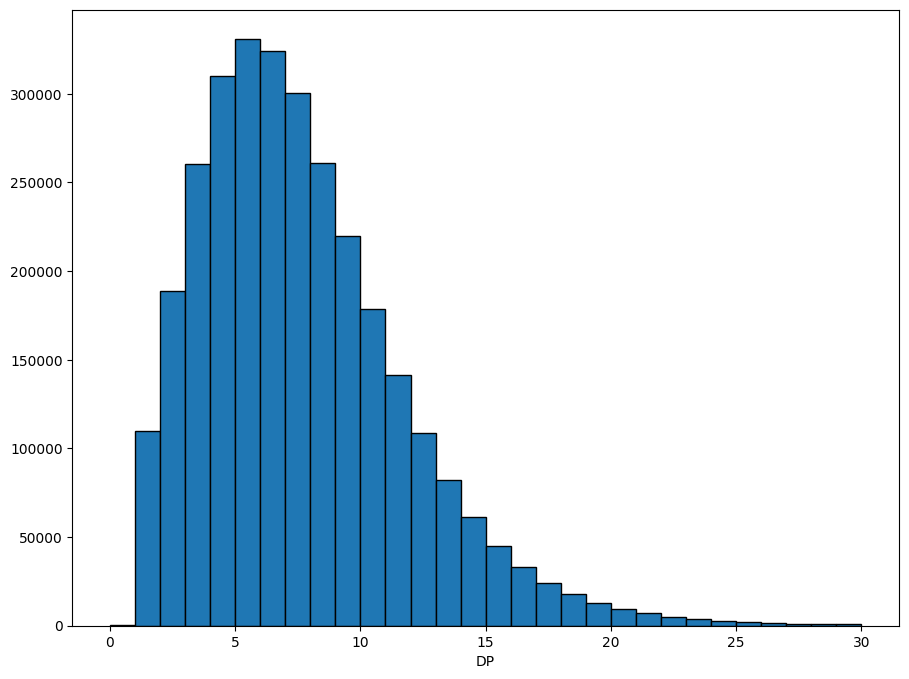

In [31]:
dp = ds.call_DP.where(ds.call_DP >= 0) # filter out missing
dp.attrs["long_name"] = "DP"
xr.plot.hist(dp, range=(0, 30), bins=30, size=8, edgecolor="black");

## Please fork this repo and do other cool things with it :) Make science reproducible, open, and fun!